# Simple ML Template — Clean Data Fast

Purpose
-------
Quick template that produces clean, model-ready datasets using the project's preprocessing classes.

What this notebook does
-----------------------
- Load raw data
- Standardize brands with ProductionCarMatcher
- Preprocess features with DataPreprocessor
- Return X_train, X_test, y_train, y_test and a fitted preprocessors

How to use
----------
1. Edit CONFIG at the top to adjust preprocessing options.
2. Run cells in order to regenerate cleaned data.
3. Add modeling cells below; re-run after changing CONFIG to test effects.

Notes
-----
- Optimized for fast iteration and clarity.
- Persist the fitted preprocessor and best model (joblib/pickle) for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import kagglehub
import warnings
import traceback
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import itertools


# Load preprocessing classes
os.chdir('../')  # Change to project root directory
# Preprocessing and utility imports
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Preprocessor_divided import DataPreprocessor
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
from utils.model_evaluation.regression_evaluation import get_regression_metrics, plot_regression_diagnostics
from utils.model_submission.model_submitter import ModelSubmitter

print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)

# CONFIGURATION - Change these as needed
CONFIG = {
    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'onehot',        # 'mean', 'onehot'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
    
    # Data splitting
    'test_size': 0.2,                 # Proportion of data for testing
    'feature_selection_size': 0.16,   # Proportion of training data for feature selection
    
    # Model selection
    'n_splits': 2,                   # Number of reppetead K-Fold splits
    'n_repeats': 2,                  # Number of repeats for K-Fold
}

print(f"Configuration: {CONFIG}")

/workspaces/ML_group_45/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'onehot', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True, 'test_size': 0.2, 'feature_selection_size': 0.16, 'n_splits': 2, 'n_repeats': 2}


In [2]:
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data.sample(500, random_state=42), # for faster testing
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data.sample(200, random_state=42), # for faster testing
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)
# dorp Brand and model columns
train_data = train_data.drop(columns=['Brand', 'model'])
test_data = test_data.drop(columns=['Brand', 'model'])

fueltype_dict = {
    'Petrol': (['petrol', 'petro', 'etrol', 'etro', 'petr', 'ptrol' ],
               [ 'diesel', 'hybrid', 'electric',  'other' ]),
    'Diesel': (['diesel', 'diese', 'iesel', 'iese', 'dise' ],
               [ 'petrol', 'hybrid', 'electric',  'other' ]),
    'Hybrid': (['hybrid', 'hybri', 'ybrid', 'ybri', 'hyb' ],
               [ 'petrol', 'diesel', 'electric',  'other' ]),
    'Electric': (['electric', 'elect', 'elec' ],
               [ 'petrol', 'diesel', 'hybrid',  'other' ]),
    'Other': (['other', 'othe', 'oth' ],
               [ 'petrol', 'diesel', 'hybrid',  'electric' ]) }

transmission_dict = {
    'Manual': ([ 'man', 'manual', 'm', 'stick', 'standard', 'mt' ],
               [ 'auto', 'semi', 'automatic', 'tiptronic', 'emi','mi','other' ]),
    'Semi-Auto': (['semi', 'semi-auto', 'tiptronic', 'emi','mi' ],
                    [ 'manual', 'stick', 'full manual', 'Other' ]),
    'Automatic': (['auto', 'automatic', 'a', 'at' ],
                  [ 'semi', 'manual', 'stick', 'tiptronic', 'emi','mi', 'other' ]) }


fuel_mapper = CardinalMapper(fueltype_dict)
transmission_mapper = CardinalMapper(transmission_dict)

print("Mapping fuelType and transmission columns...")
train_data['fuelType'] = fuel_mapper.fit_transform(train_data['fuelType'])
train_data['transmission'] = transmission_mapper.fit_transform(train_data['transmission'])
print(f"fuelType value counts:\n{train_data['fuelType'].value_counts()}")
test_data['fuelType'] = fuel_mapper.fit_transform(test_data['fuelType'])
test_data['transmission'] = transmission_mapper.fit_transform(test_data['transmission'])
print(f"transmission value counts:\n{train_data['transmission'].value_counts()}")


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 500 records...


Processing records: 100%|██████████| 500/500 [00:01<00:00, 408.92it/s]


Cleaning 200 records...


Processing records: 100%|██████████| 200/200 [00:00<00:00, 411.60it/s]

Mapping fuelType and transmission columns...
fuelType value counts:
fuelType
Petrol    290
Diesel    186
Hybrid     12
Other      12
Name: count, dtype: int64
transmission value counts:
transmission
Manual       264
Semi-Auto    123
Automatic     91
Other         22
Name: count, dtype: int64


In [3]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [4]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 1600,
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'clean_make': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # use mean encoding for make in any case, regardless of CONFIG because of high cardinality
    },
    'clean_model': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean', # use mean encoding for models in any case, regardless of CONFIG because of high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],

    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],
    }
}

In [5]:
data_temp = train_data.sample(frac=CONFIG['test_size'], random_state=CONFIG['random_state'])
data_val = train_data.drop(data_temp.index)
data_model_sel = data_temp.sample(frac=CONFIG['feature_selection_size'] , random_state=CONFIG['random_state'])
data_train = data_temp.drop(data_model_sel.index)

print(f"\n✅ DATA SPLIT COMPLETE!")
print(f"   data_train: {data_train.shape}")
print(f"   data_model_sel: {data_model_sel.shape}")
print(f"   data_val: {data_val.shape}")

# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])


for feature, feature_config in feature_configs.items():
    if feature in data_train.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
X_train, y_train = preprocessor.fit_transform(data_train)
X_model_sel, y_model_sel = preprocessor.transform(data_model_sel)
X_val, y_val = preprocessor.transform(data_val)
X_test, y_test = preprocessor.transform(train_data)

del data_temp  # free memory



✅ DATA SPLIT COMPLETE!
   data_train: (84, 14)
   data_model_sel: (16, 14)
   data_val: (400, 14)


## Data is clean — start modeling

Summary
-------
Processed outputs available:
- X_feature_selection — feature selection matrix (scaled / encoded)
- X_train, X_test — feature matrices (scaled / encoded)
- X_val — validation feature matrix
- y_train, y_test — target vectors
- preprocessor — fitted DataPreprocessor (use to transform new data)

Quick checklist
---------------
1. Verify feature set and shapes.
2. Select features and models.
3. Run baseline experiments and record metrics.
4. Persist preprocessor and best model (joblib / pickle).


In [6]:
X_train.head()

,carID,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,clean_make,clean_model,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
73,68669,0.272727,0.382340,-1.611102,-0.138462,-0.190476,0.185714,1.003354,0.0,9724.500000,13750.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
374,65856,0.545455,0.633650,-1.789523,1.044474,0.952381,0.114286,-1.716299,0.0,16754.600000,13600.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
155,12492,0.090909,-0.008307,0.440743,0.909281,0.952381,0.285714,1.003354,0.0,15349.181818,19674.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
394,8748,0.090909,0.091347,0.529954,-0.053966,0.952381,0.557143,1.003354,0.0,17266.117647,15487.166667,0.0,0.0,1.0,1.0,0.0,0.0,0.0
377,27783,0.272727,0.264428,0.440743,-0.053966,0.952381,0.885714,0.626283,0.0,18234.800000,13750.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# choose all the features with cardinality 2
boolean_features = X_train.columns[X_train.nunique() == 2].tolist()
boolean_features

['hasDamage',
 'transmission_Automatic',
 'transmission_Manual',
 'transmission_Semi-Auto',
 'fuelType_Diesel',
 'fuelType_Hybrid',
 'fuelType_Other',
 'fuelType_Petrol']

In [8]:
from utils.feature_selection.feature_selection import NumericalFeatureSelector, CategoricalFeatureSelector


cat_selector = CategoricalFeatureSelector(
    X_train=X_model_sel,
    y_train=y_model_sel,
    categorical_encoded_features=boolean_features,
    corr_threshold=0.8,
    importance_threshold=0.001)
print("✅ Classe inicializada com sucesso!")

# Testar método por método (sem chi2)
print("\n1️⃣ Testando correlation_redundancy...")
corr_result = cat_selector.correlation_redundancy()
print(f"   ✅ Completado: {len(corr_result)} features analisadas")

print("\n2️⃣ Testando mutual_information_relevance...")
mi_result = cat_selector.mutual_information_relevance()
print(f"   ✅ Completado: MI scores calculados")

print("\n3️⃣ Testando anova_relevance...")
anova_result = cat_selector.anova_relevance()
print(f"   ✅ Completado: ANOVA F-scores calculados")

print("\n4️⃣ Testando random_forest_importance...")
rf_result = cat_selector.random_forest_importance()
print(f"   ✅ Completado: RF importance calculado")

print("\n5️⃣ Testando rfe_all_models...")
rfe_results = cat_selector.rfe_all_models()
print(f"   ✅ Completado: {len(rfe_results)} modelos RFE")

print("\n6️⃣ Testando lasso_all_scalers...")
lasso_results = cat_selector.lasso_all_scalers()
print(f"   ✅ Completado: {len(lasso_results)} versões Lasso")

# 🎯 TESTE FINAL
print("\n" + "🔬 COMPILANDO TODOS OS RESULTADOS..." + "="*40)
final_results_cat = cat_selector.compile_results()

print("✅ COMPILAÇÃO CONCLUÍDA!")
print(f"\n📊 RESULTADOS FINAIS:")
print(final_results_cat[['Feature', 'Total_Accepted', 'Accept_Rate', 'Final_Decision']].to_string(index=False))

✅ Classe inicializada com sucesso!

1️⃣ Testando correlation_redundancy...
   ✅ Completado: 8 features analisadas

2️⃣ Testando mutual_information_relevance...
   ✅ Completado: MI scores calculados

3️⃣ Testando anova_relevance...
   ✅ Completado: ANOVA F-scores calculados

4️⃣ Testando random_forest_importance...
   ✅ Completado: RF importance calculado

5️⃣ Testando rfe_all_models...
   ✅ Completado: 5 modelos RFE

6️⃣ Testando lasso_all_scalers...
   ✅ Completado: 3 versões Lasso

🔬 COMPILANDO TODOS OS RESULTADOS...========================================
✅ COMPILAÇÃO CONCLUÍDA!

📊 RESULTADOS FINAIS:
               Feature  Total_Accepted  Accept_Rate Final_Decision
             hasDamage               0     0.000000           Drop
transmission_Automatic               9     0.750000           Keep
   transmission_Manual               9     0.750000           Keep
transmission_Semi-Auto              12     1.000000           Keep
       fuelType_Diesel               5     0.416667   

In [9]:
from utils.feature_selection.feature_selection import NumericalFeatureSelector

numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
# remove boolean features from numerical features
numerical_features = [feat for feat in numerical_features if feat not in boolean_features]
fs = NumericalFeatureSelector(
    X_train=X_model_sel,
    y_train=y_model_sel,
    numeric_features=numerical_features,
    X_val=X_val,
    y_val=y_val
)

# ================================================================
# 🔍 Apply Selection Methods
# ================================================================
vif_results = fs.vif_analysis()
spearman_redundancy = fs.spearman_redundancy()
spearman_relevance = fs.spearman_relevance(threshold=0.1)

rfe_results = fs.rfe_all_models()
ridge_results = fs.ridge_all()
lasso_results = fs.lasso_all()

# ================================================================
# 🧾 Compile Final Table
# ================================================================
final_results_num = fs.compile_results()

print("\n=== 🔹 Feature Selection Summary ===")
display(final_results_num)



=== 🔹 Feature Selection Summary ===


,Feature,VIF,Accepted_x,Max_SpearmanCorr,Accepted_y,Spearman_TargetCorr,Accepted,RFE_DecisionTree,RFE_RandomForest,RFE_LR_MinMax,RFE_LR_Standard,RFE_LR_Robust,Ridge_MinMax,Ridge_Standard,Ridge_Robust,Lasso_MinMax,Lasso_Standard,Lasso_Robust,Total_Accepted,Final_Decision
0,carID,9.585225,False,NaN,False,0.029412,False,True,True,False,False,False,True,True,True,False,False,False,5,Drop
1,year,7.155345,False,0.000000,True,0.728371,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
2,mileage,4.481451,True,0.863580,False,0.660780,True,True,True,False,False,False,True,True,True,False,False,False,7,Drop
3,tax,2.224982,True,0.402408,True,0.313954,True,False,False,False,False,False,True,True,True,False,False,True,7,Drop
4,mpg,2.279446,True,0.391215,True,0.382641,True,False,False,True,True,True,True,True,True,False,True,True,11,Keep
5,engineSize,2.650462,True,0.321148,True,0.105616,True,False,True,True,True,True,True,True,True,False,True,True,12,Keep
6,paintQuality%,9.267214,False,0.367577,True,0.126471,True,False,False,True,True,True,True,True,True,False,False,False,8,Keep
7,previousOwners,2.177896,True,0.468599,True,0.176685,True,True,False,True,True,True,True,True,True,False,False,False,10,Keep
8,clean_make,48.181679,False,0.403915,True,0.293909,True,False,True,False,False,False,True,True,True,False,False,False,6,Drop
9,clean_model,37.717688,False,0.474902,True,0.114960,True,True,False,False,False,False,True,True,True,False,False,False,6,Drop


In [10]:
selected_boolean_features = final_results_cat[final_results_cat['Final_Decision'] == 'Keep']['Feature'].tolist()
selected_numerical_features = final_results_num[final_results_num['Final_Decision'] == 'Keep']['Feature'].tolist()


choosen_features = selected_numerical_features + selected_boolean_features
choosen_features

['year',
 'mpg',
 'engineSize',
 'paintQuality%',
 'previousOwners',
 'transmission_Automatic',
 'transmission_Manual',
 'transmission_Semi-Auto']

In [11]:
def evaluate_model_repeated_kfold(model, raw_train_data, preprocessor, n_splits=10, n_repeats=10, random_state=42):
    """
    Evaluates a model using Repeated K-Fold Cross-Validation, returning the 
    mean RMSE and its 95% confidence interval.
    
    Args:
        model: The instantiated scikit-learn model.
        raw_train_data (pd.DataFrame): The original raw training data.
        preprocessor (object): An object with a .transform(raw_data) method 
                               that returns (X, y) pandas objects.
        n_splits (int): Number of folds (K) in K-Fold.
        n_repeats (int): Number of times the K-Fold process is repeated.
        random_state (int): Seed for shuffling data.
        
    Returns:
        tuple: (mean_score, conf_interval)
    """
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    total_folds = n_splits * n_repeats
    scores = np.zeros(total_folds)
    
    # 1. Transform raw data into features (X) and target (y)
    X, y = preprocessor.transform(raw_train_data)
    
    # 2. Iterate through all folds
    for fold_index, (train_index, test_index) in enumerate(tqdm.tqdm(rkf.split(X), total=total_folds, desc="Evaluating Folds")):
        
        # Split data for the current fold
        X_rkf_train, X_rkf_test = X.iloc[train_index], X.iloc[test_index]
        y_rkf_train, y_rkf_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train, Predict, and Score
        model.fit(X_rkf_train, y_rkf_train)
        y_pred = model.predict(X_rkf_test)
        
        # Calculate mean absolute error
        score = mean_absolute_error(y_rkf_test, y_pred)
        scores[fold_index] = score
    
    # 3. Calculate statistics
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # Calculate 95% Confidence Interval (using 1.96 standard errors)
    conf_interval = 1.96 * (std_score / np.sqrt(len(scores)))
    
    return mean_score, conf_interval


def run_hyperparameter_tuning(train_data,
                              preprocessor,
                              list_of_dictionaries,
                              model_class=RandomForestRegressor,
                              n_splits=2, n_repeats=2):
    """
    Performs Repeated K-Fold tuning for RandomForestRegressor and plots results.
    """

    # Define the parameter grid to search
    
    scores = []
    print(f"--- Starting {model_class.__name__} Hyperparameter Tuning ({n_splits}x{n_repeats} Folds) ---")
    
    # Perform Grid Search
    for  _ , combination_params in enumerate(list_of_dictionaries):
            
            # Instantiate the model
            model = model_class(**combination_params)
            
            # Evaluate
            mean_score, conf_interval = evaluate_model_repeated_kfold(model, 
                                                                     train_data, 
                                                                     preprocessor,
                                                                     n_splits=n_splits, 
                                                                     n_repeats=n_repeats,
                                                                     random_state=CONFIG['random_state'])
            
            # Store and Print Results
            scores.append((mean_score, conf_interval))
            print(f"Result: {combination_params}-> RMSE={mean_score:.4f} ± {conf_interval:.4f}")
            
    # --- Plotting the Results ---
    print(f"\n--- Generating Plot {model_class.__name__} ---")
    labels = [f'{config_}'for config_ in list_of_dictionaries ]
    mean_scores = [v[0] for v in scores]
    conf_intervals = [v[1] for v in scores]

    x = np.arange(len(labels))

    plt.figure(figsize=(12, 6))
    plt.bar(x, mean_scores, yerr=conf_intervals, capsize=5, color='teal', alpha=0.8)
    
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('RMSE (Root Mean Squared Error)')
    plt.title(f'{model_class.__name__} Hyperparameter Tuning Results (Repeated K-Fold)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Determine the best parameters
    best_params = list_of_dictionaries[np.argmin([s[0] for s in scores])]
    best_rmse  = min([s[0] for s in scores])
    
    print(f"\nOptimization Complete. Best Parameters: {best_params} with Mean RMSE={best_rmse:.4f}")
    
    return scores, best_params





In [12]:
config_parameters_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}   
keys = config_parameters_svr.keys()
values = config_parameters_svr.values()
print(values)
combinations = itertools.product(*values)
print(f"Total combinations: {len(list(itertools.product(*values)))}")

dict_values([[0.1, 1, 10], [0.01, 0.1, 1], ['linear', 'rbf', 'poly']])
Total combinations: 27


--- Starting SVR Hyperparameter Tuning (2x2 Folds) ---


Evaluating Folds: 100%|██████████| 4/4 [00:00<00:00, 135.08it/s]


Result: {'C': 0.1}-> RMSE=6710.9349 ± 203.5796


Evaluating Folds: 100%|██████████| 4/4 [00:00<00:00, 140.30it/s]


Result: {'C': 1}-> RMSE=6709.3095 ± 203.6057


Evaluating Folds: 100%|██████████| 4/4 [00:00<00:00, 125.58it/s]

Result: {'C': 10}-> RMSE=6693.0892 ± 203.2941

--- Generating Plot SVR ---


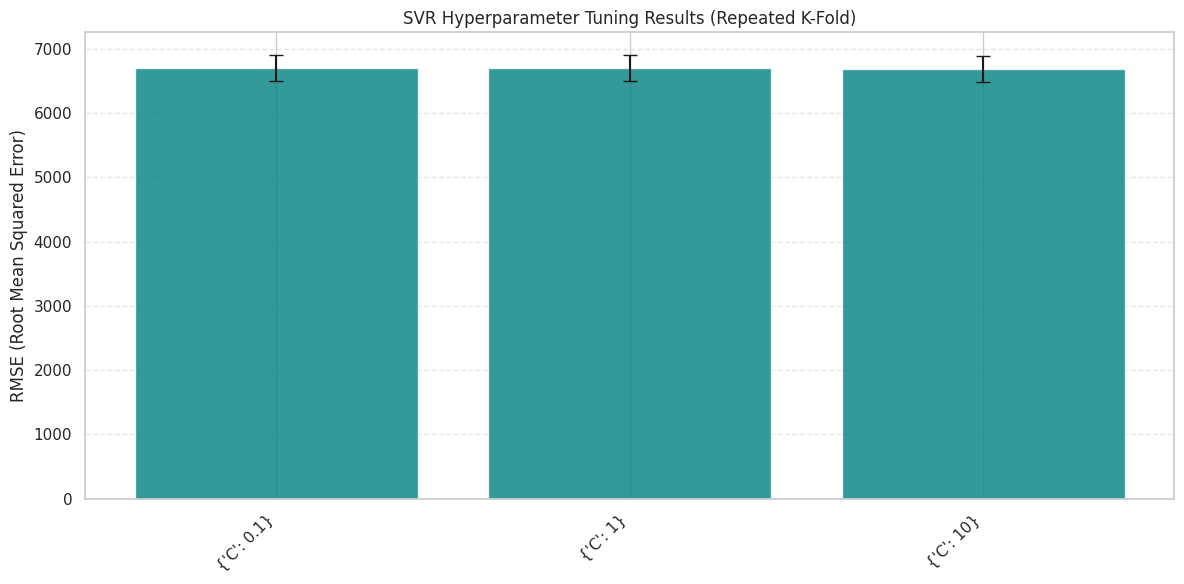


Optimization Complete. Best Parameters: {'C': 10} with Mean RMSE=6693.0892


In [ ]:
# import svm for regression, 

config_parameters_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}   
keys = config_parameters_svr.keys()
values = config_parameters_svr.values()
combinations = itertools.product(*values)
list_of_dictionaries_svr = [dict(zip(keys, v)) for v in combinations]
 

results, best_params = run_hyperparameter_tuning(train_data, preprocessor=preprocessor,
                                                list_of_dictionaries=list_of_dictionaries_svr,
                                                 model_class=SVR,
                                                 n_splits=CONFIG['n_splits']
                                                 , n_repeats=CONFIG['n_repeats'])

   Support Vector  RMSE: 9788
   Support Vector  R²: -0.081
   Support Vector MAE: 6728

Regression Metrics:
                                      Score  \
Metric                                       
R-squared ($R^2$)                  -0.0813   
Explained Variance Score            0.0008   
Root Mean Squared Error (RMSE)  9,787.8238   
Mean Absolute Error (MAE)       6,727.5653   
Median Absolute Error (MedAE)   4,628.1029   

                                                                   Interpretation  
Metric                                                                             
R-squared ($R^2$)               Proportion of variance explained by the model ...  
Explained Variance Score        The variance in the error, a lower value is be...  
Root Mean Squared Error (RMSE)  Average magnitude of errors (same units as tar...  
Mean Absolute Error (MAE)       Average absolute difference between true and p...  
Median Absolute Error (MedAE)   The median of all absolute erro

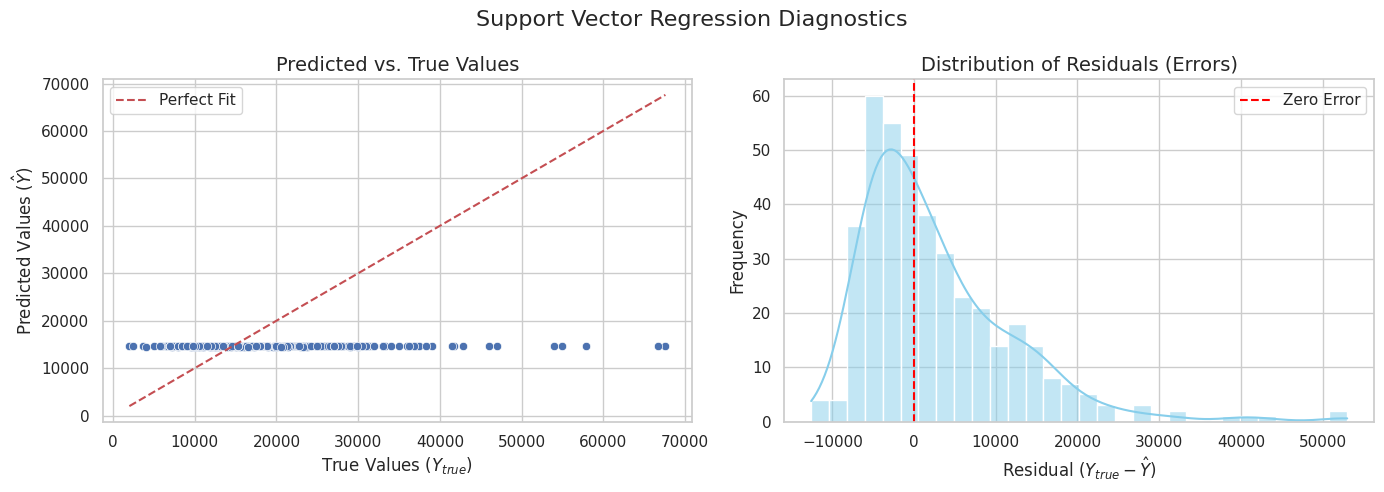

In [14]:
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Quick model test
model = SVR(**best_params)
model.fit(X_train[numerical_features], y_train)

predictions = model.predict(X_val[numerical_features])
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print(f"   Support Vector  RMSE: {rmse:.0f}")
print(f"   Support Vector  R²: {r2:.3f}")
print(f"   Support Vector MAE: {mae:.0f}")
metrics_df = get_regression_metrics(y_val, predictions)
print("\nRegression Metrics:\n", metrics_df)
plot_regression_diagnostics(y_val, predictions, title="Support Vector Regression Diagnostics")

In [15]:
# let's make a class that, given a model instance and th test data and the colums to use, returns the predicted values paired to the index and saves them to be submitted on kaggle
# also it saves the model to a pickle file for future use and reproducibility
    # Example usage:
submitter = ModelSubmitter(model, X_test, numerical_features, index_column='carID')
submitter.save_submission('random_forest_submission.csv')

Submission saved to Submission/20251028_random_forest_submission.csv
Model saved to Submission/20251028_random_forest_submission_model.pkl
